In [1]:
from idlelib.iomenu import errors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
train =pd.read_csv('used_car_train_20200313.csv',sep=' ')
test = pd.read_csv('used_car_testB_20200421.csv',sep=' ')
combine = [train,test]

In [3]:
train.shape

(150000, 31)

In [4]:
train.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [6]:
print(train.isnull().sum())
print('-'*40)
test.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64
----------------------------------------


SaleID                  0
name                    0
regDate                 0
model                   0
brand                   0
bodyType             1504
fuelType             2924
gearbox              1968
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

<Axes: >

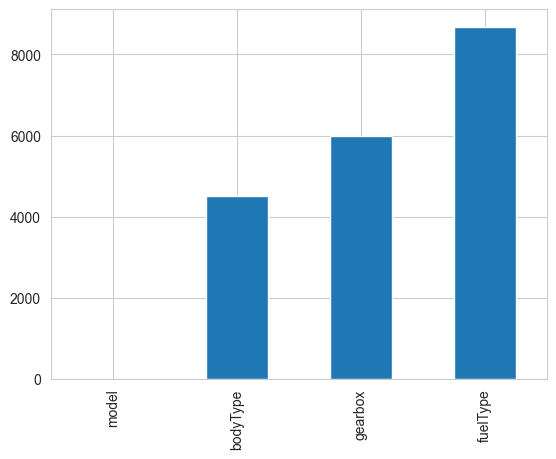

In [7]:
# 空值可视化
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

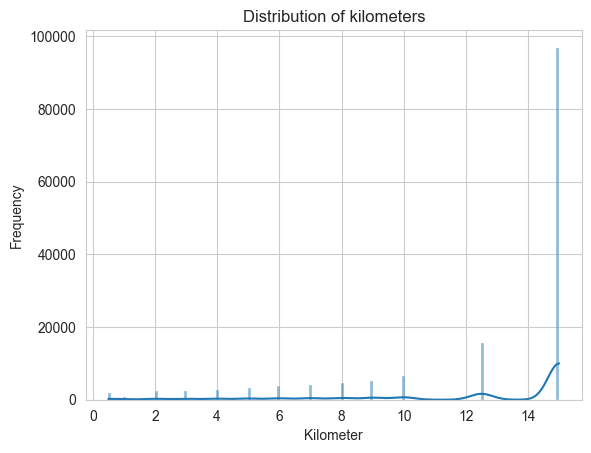

In [8]:
sns.histplot(train['kilometer'], kde=True)
plt.title('Distribution of kilometers')
plt.xlabel('Kilometer')
plt.ylabel('Frequency')
plt.show()

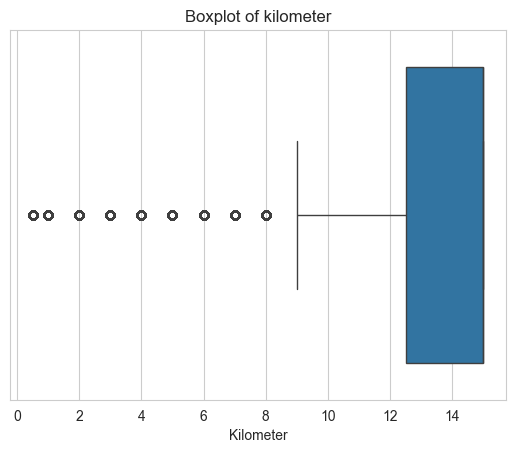

In [9]:
# 绘制 kilometers 列的箱线图
sns.boxplot(x=train['kilometer'])
plt.title('Boxplot of kilometer')
plt.xlabel('Kilometer')
plt.show()

# 对缺失值处理
训练集中
model 缺失1条
bodyType             4506
fuelType             8680
gearbox              5981





gearbox,变速箱，对其缺失值采取众数的填补

In [10]:
train['notRepairedDamage'].value_counts()

notRepairedDamage
0.0    111361
-       24324
1.0     14315
Name: count, dtype: int64

In [11]:
# 这里先不对- 进行处理，先替换成Nan
train['notRepairedDamage'].replace('-',np.nan,inplace=True)

In [12]:
train.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage    24324
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

In [13]:
test.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   0
brand                   0
bodyType             1504
fuelType             2924
gearbox              1968
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

In [14]:
test['notRepairedDamage'].value_counts()

notRepairedDamage
0.0    37224
-       8069
1.0     4707
Name: count, dtype: int64

In [15]:
test['notRepairedDamage'].replace('-', np.nan, inplace=True)

In [16]:
print(train['notRepairedDamage'].dtype)
print(train['notRepairedDamage'].unique())

object
['0.0' nan '1.0']


In [17]:
train["seller"].value_counts()
# 该数据严重倾斜，可以删掉

seller
0    149999
1         1
Name: count, dtype: int64

In [18]:
train['offerType'].value_counts()
#同理

offerType
0    150000
Name: count, dtype: int64

In [19]:
# 了解预测值的分布
train['price']

0         1850
1         3600
2         6222
3         2400
4         5200
          ... 
149995    5900
149996    9500
149997    7500
149998    4999
149999    4700
Name: price, Length: 150000, dtype: int64

In [20]:
train['price'].value_counts()

price
500      2337
1500     2158
1200     1922
1000     1850
2500     1821
         ... 
36700       1
15413       1
83000       1
14580       1
4737        1
Name: count, Length: 3763, dtype: int64

<Axes: title={'center': 'Log Normal'}, xlabel='price'>

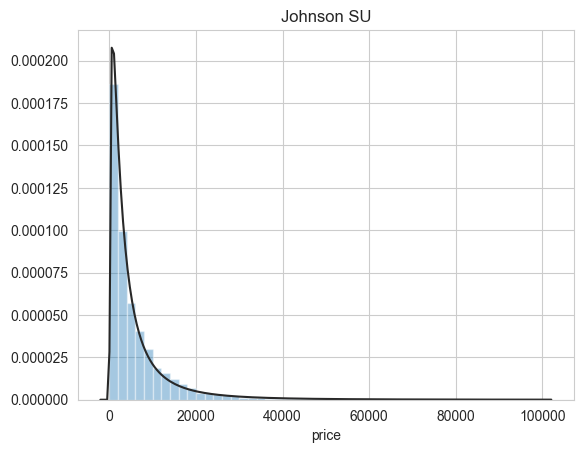

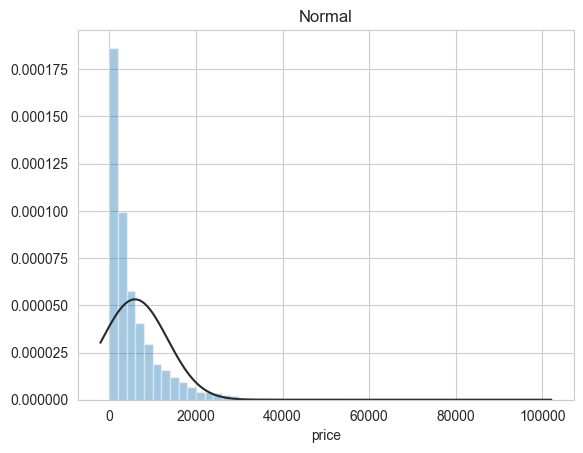

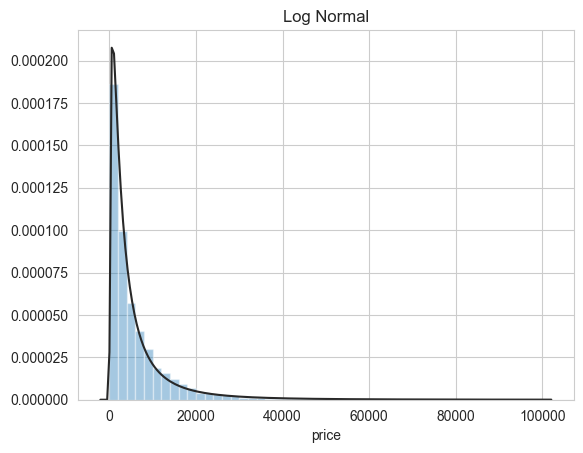

In [21]:
# 总体分布情况
import scipy.stats as st
y = train['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

价格不服从正态分布，所以在进行回归之前，它必须进行转换，无分界约翰逊分布和对数分布表现更好一点，本次实验采取对数转换。

从数据中可以看出大于20000的数较少


In [22]:
def bodyType_fill(train,test):
    train_value = train['bodyType'].mode()[0]
    test_value = test['bodyType'].mode()[0]

    train['bodyType'] = train['bodyType'].fillna(train_value)
    test['bodyType'] = test['bodyType'].fillna(test_value)

In [23]:
def fuelType_fill(train,test):
    train_value = train['fuelType'].mode()[0]
    test_value = test['fuelType'].mode()[0]

    train['fuelType'] = train['fuelType'].fillna(train_value)
    test['fuelType'] = test['fuelType'].fillna(test_value)

In [24]:
def gearbox_fill(train,test):
    train_value = train['gearbox'].mode()[0]
    test_value = test['gearbox'].mode()[0]

    train['gearbox'] = train['gearbox'].fillna(train_value)
    test['gearbox'] = test['gearbox'].fillna(test_value)

In [25]:
# 进行验证
print(train['gearbox'].isnull().sum())

print(test['gearbox'].isnull().sum())

5981
1968


In [26]:
# 对power的缺失值,留在后续进行处理

In [27]:
def power_fill(train,test):
    train_value = train['power'].mean()
    test_value = test['power'].mean()
    train['power'] = train['power'].fillna(train_value)
    test['power'] = test['power'].fillna(test_value)


In [28]:
def kilometer_fill(train,test):
    train_value = train['kilometer'].mean()
    test_value = test['kilometer'].mean()
    train['kilometer'] = train['kilometer'].fillna(train_value)
    test['kilometer'] = test['kilometer'].fillna(test_value)


In [29]:
def notRepairedDamage_fill(train, test):
    # 合并 train 和 test 集的数据用于计算众数
    combined_data = pd.concat([train['notRepairedDamage'], test['notRepairedDamage']])
    # 去除 '-' 并计算众数
    valid_data = combined_data[combined_data != '-']
    # 使用 pandas 的 mode 方法计算众数
    mode_value = valid_data.mode()[0]

    # 用众数填充 train 和 test 集中的 '-'
    train['notRepairedDamage'] = train['notRepairedDamage'].replace('-', mode_value)
    test['notRepairedDamage'] = test['notRepairedDamage'].replace('-', mode_value)

    return train, test

In [30]:
# v12,v13,v14
def v_fill(train,test,i):
    train_value = train[f'v_{i}'].mode()[0]
    test_value = test[f'v_{i}'].mode()[0]

    train[f'v_{i}'] = train[f'v_{i}'].fillna(train_value)
    test[f'v_{i}'] = test[f'v_{i}'].fillna(test_value)

In [31]:
def convert_to_numeric(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [32]:
def date_fill(series):
    """
    安全转换日期列并自动用众数填充无效值

    参数：
        series: pd.Series 原始日期列

    返回：
        pd.Series 转换后的日期列（已用众数填充无效值）
    """
    # 预处理：转换为字符串并去除空格
    date_str = series.astype(str).str.strip()

    # 第一步：尝试严格转换
    # 1. 格式有效性验证
    valid_mask = (
        date_str.str.len() == 8                # 长度必须为8
        & date_str.str.isdigit()               # 必须全为数字
        & date_str.str[4:6].between('01', '12')  # 月份必须有效
        & date_str.str[6:8].between('01', '31')  # 简化日期校验
    )

    # 2. 严格转换（仅转换有效格式）
    strict_dates = pd.to_datetime(
        date_str.where(valid_mask, np.nan),
        format='%Y%m%d',
        errors='coerce'
    )

    # 第二步：计算众数
    # 1. 排除NaT后的有效众数
    mode_result = strict_dates.dropna().mode()

    # 2. 处理无有效日期的情况
    if len(mode_result) == 0:
        mode_date = pd.NaT  # 如果全无效则保留NaT
    else:
        mode_date = mode_result[0]  # 取第一个众数

    # 第三步：填充并返回
    return strict_dates.fillna(mode_date)

In [33]:
#数据加载
def load_data():
    train = pd.read_csv('used_car_train_20200313.csv', sep=' ')
    test = pd.read_csv('used_car_testB_20200421.csv', sep=' ')
    return train, test

#数据预处理
def data_processing(train, test):
    # 缺失值处理
    notRepairedDamage_fill(train, test)
    gearbox_fill(train, test)
    bodyType_fill(train, test)
    fuelType_fill(train, test)

    convert_to_numeric(train)
    convert_to_numeric(test)
    # 将 regDate 和 creatDate 转换成日期格式，并对缺失值进行处理
    for col in ['creatDate', 'regDate']:
        train[col] = date_fill(train[col])
        test[col] = date_fill(test[col])

# 特征工程
def feature_engineering(df):
    """时间特征处理"""
    # 计算车龄
    df['creatDate'] = pd.to_datetime(df['creatDate'], format='%Y%m%d')
    df['regDate'] = pd.to_datetime(df['regDate'], format='%Y%m%d')

    df['car_age'] = (df['creatDate'].dt.year - df['regDate'].dt.year) + (df['creatDate'].dt.month - df['regDate'].dt.month) / 12

    # 注册日期特征
    df['regDate_year'] = df['regDate'].dt.year
    df['regDate_month'] = df['regDate'].dt.month
    df['regDate_day'] = df['regDate'].dt.day

    """类别特征处理"""
    # 高频类别编码
    for col in ['brand', 'regionCode']:
        freq = df[col].value_counts(normalize=True)
        df[f'{col}_freq'] = df[col].map(freq)

    # 特殊类别处理
    df['notRepairedDamage'] = pd.to_numeric(df['notRepairedDamage'], errors='coerce')
    df['notRepairedDamage'] = df['notRepairedDamage'].astype('category').cat.codes

    """数值特征处理"""
    # 发动机功率异常处理
    df['power'] = np.where(df['power'] > 600, 600, df['power'])
    df['power'] = np.where(df['power'] < 0, 0, df['power'])

    # 行驶里程分箱
    df['kilometer_bin'] = pd.cut(df['kilometer'], bins=10, labels=False)

    """匿名特征处理"""
    v_cols = [f'v_{i}' for i in range(15)]
    scaler = StandardScaler()
    df[v_cols] = scaler.fit_transform(df[v_cols])

    """特征筛选"""
    drop_cols = ['SaleID', 'name', 'regDate', 'creatDate', 'model', 'seller', 'offerType']
    df.drop(drop_cols, axis=1, inplace=True, errors='ignore')

    return df

# 建模流程
def lgb_model(train, test):
    # 数据准备
    y_train = np.log1p(train['price'])  # 对数变换
    X_train = train.drop(['price'], axis=1)
    X_test = test.copy()

    # 初始化模型参数
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mae',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'verbosity': -1  # 完全静默模式
    }

    # 交叉验证
    folds = KFold(n_splits=5, shuffle=True, random_state=2022)
    predictions = np.zeros(len(X_test))
    feature_importance = pd.DataFrame()

    best_mae = float('inf')
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f'Fold{fold_ + 1}')
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        model = lgb.train(
            params,
            train_set=trn_data,
            num_boost_round=10000,
            valid_sets=[trn_data, val_data],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.log_evaluation(period=500),
                lgb.early_stopping(stopping_rounds=100)  # 显式回调
            ]
        )

        # 计算验证集上的 MAE
        val_preds = model.predict(X_train.iloc[val_idx], num_iteration=model.best_iteration)
        mae = np.mean(np.abs(y_train.iloc[val_idx] - val_preds))

        # 更新最佳 MAE
        if mae < best_mae:
            best_mae = mae

        # 特征重要性
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = fold_ + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        # 预测
        predictions += model.predict(X_test, num_iteration=model.best_iteration) / folds.n_splits

    print(f"最好一次交叉验证的平均绝对误差 (MAE): {best_mae}")

    return np.expm1(predictions), feature_importance  # 逆变换



In [35]:

# --------------------------
# 主流程
# --------------------------
if __name__ == '__main__':
    # 数据加载
    train,test = load_data()

    # 数据预处理
    print("Data processing ...")
    data_processing(train,test)
    # 特征工程
    print("Processing train data...")
    train = feature_engineering(train)
    print("Processing test data...")
    test = feature_engineering(test)

    # 建模预测
    print("Start training...")
    preds, feature_importance = lgb_model(train,test)

Data processing ...
Processing train data...
Processing test data...
Start training...
Fold1
Training until validation scores don't improve for 100 rounds
[500]	train's l1: 0.16301	valid's l1: 0.165496
[1000]	train's l1: 0.151654	valid's l1: 0.156412
[1500]	train's l1: 0.146418	valid's l1: 0.153087
[2000]	train's l1: 0.142281	valid's l1: 0.150895
[2500]	train's l1: 0.138988	valid's l1: 0.149451
[3000]	train's l1: 0.136093	valid's l1: 0.14834
[3500]	train's l1: 0.133459	valid's l1: 0.147326
[4000]	train's l1: 0.131079	valid's l1: 0.146532
[4500]	train's l1: 0.12883	valid's l1: 0.145704
[5000]	train's l1: 0.126795	valid's l1: 0.145145
[5500]	train's l1: 0.124906	valid's l1: 0.144723
[6000]	train's l1: 0.123079	valid's l1: 0.144261
[6500]	train's l1: 0.121254	valid's l1: 0.143836
[7000]	train's l1: 0.119524	valid's l1: 0.143342
[7500]	train's l1: 0.117972	valid's l1: 0.142993
[8000]	train's l1: 0.116426	valid's l1: 0.142713
[8500]	train's l1: 0.114873	valid's l1: 0.142349
[9000]	train's l

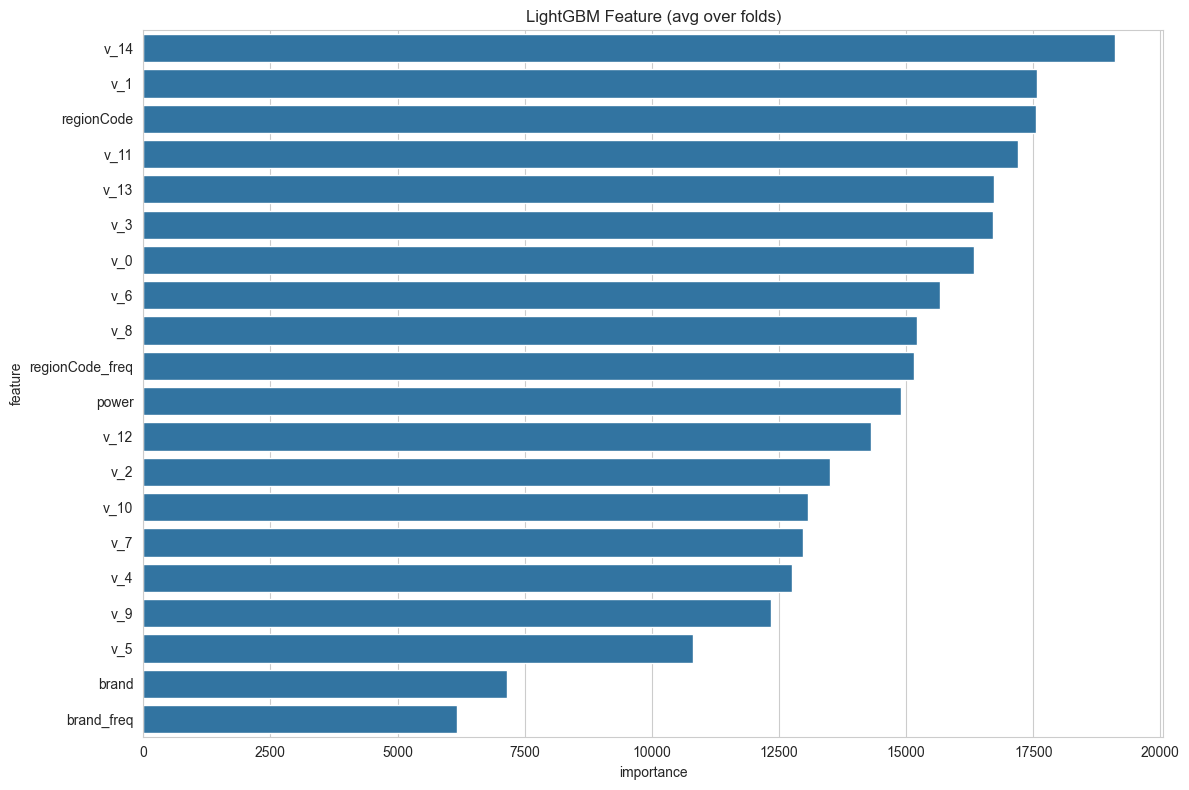

In [36]:
import seaborn as sns
# 生成提交文件

submission = pd.read_csv('used_car_testB_20200421.csv',sep=r'\s+',engine='python')[['SaleID']]
submission['price'] = preds
submission.to_csv('./submission.csv',index=False)


# 特征重要性分析
plt.figure(figsize=(12,8))
sns.barplot(x="importance",y="feature",data=feature_importance.groupby('feature',as_index=False)['importance'].mean(0).sort_values(by='importance',ascending=False).head(20))
plt.title('LightGBM Feature (avg over folds)')
plt.tight_layout()
plt.savefig('./feature_importance.png')